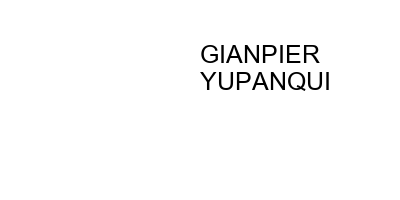

In [2]:
from PIL import Image, ImageDraw, ImageFont

img = Image.new('RGB', (400, 200), color='white')
myFont = ImageFont.truetype("arial.ttf", 25, encoding="unic")

d = ImageDraw.Draw(img)
text = '''GIANPIER
YUPANQUI'''
d.text((200, 40), text , fill='black', align ="left", font=myFont)


#img.save('imagen ctexto.png')
display(img)

# Campo Lista Spark

Para usar pyspark en una notebook debemos tener

In [1]:
import os
import sys

print(os.path.dirname(sys.executable))

c:\Users\GIANPIER\anaconda3


In [ ]:
#pip install findspark

In [1]:
import findspark
findspark.init()

In [2]:
# Creamos la session de Spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()
print('Apache Spark Version :' + spark.sparkContext.version)

sc = spark.sparkContext

Apache Spark Version :3.3.1


In [4]:
jsonString = """{"startAt": "MOBILE", "nup": "06533942", "validationStatus": [{"flow": "camenores", "status": {"code": "NOT_A_TEENAGER_ERROR", "description": "The person is not a teenager", "detail": "The person is not a teenager, it doesn't have the required age for this product", "date": {"$date": 1698624030886}}, "passed": false}, {"flow": "supercuenta", "passed": true}, {"flow": "paquetes", "passed": true}], "beginningFlow": "paquetes"}"""
df_json=spark.createDataFrame([(jsonString, "2023-04-20")],["json","partition_date"])
df_json.show()

+--------------------+--------------+
|                json|partition_date|
+--------------------+--------------+
|{"startAt": "MOBI...|    2023-04-20|
+--------------------+--------------+



Bueno, ya tenemos la columna en un dataframe (este paso anterior no sera necesario porque ustedes se conectan al lago)

Ahora vamos a pasarle la estructura que deberia tener este texto plano, que es **como queremos que se comporte**

Al verlo intuimos lo siguiente: Una lista de estructuras, la cual se escribe en SPARK de la siguiente forma

In [5]:
schema = StructType(
      [
        StructField('startAt',  StringType(), True ),
        StructField('nup', StringType(), True),
        StructField('validationStatus', ArrayType(StructType([
            StructField('flow',  StringType(), True ),
            StructField('passed',  StringType(), True ),
            StructField('status',  StructType([
                StructField('code',  StringType(), True ),
                StructField('date',  StructType([
                    StructField('$date',  StringType(), True ) 
                ]), True ),
                StructField('description',  StringType(), True ),
                StructField('detail',  StringType(), True )
            ]), True )
        ])), True),
        StructField('beginningFlow', StringType(), True)
      ]
    )

#  creamos una nueva columna: withColumn("un alias", from_json("la columna a parsear", el_schema_creado))
mapped_df = df_json.withColumn("spark", from_json("json", schema))

In [7]:
mapped_df.printSchema()

root
 |-- json: string (nullable = true)
 |-- partition_date: string (nullable = true)
 |-- spark: struct (nullable = true)
 |    |-- startAt: string (nullable = true)
 |    |-- nup: string (nullable = true)
 |    |-- validationStatus: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- flow: string (nullable = true)
 |    |    |    |-- passed: string (nullable = true)
 |    |    |    |-- status: struct (nullable = true)
 |    |    |    |    |-- code: string (nullable = true)
 |    |    |    |    |-- date: struct (nullable = true)
 |    |    |    |    |    |-- $date: string (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- detail: string (nullable = true)
 |    |-- beginningFlow: string (nullable = true)



In [8]:
df = mapped_df.select(col("spark.*"),col("partition_date"))
df.printSchema()

root
 |-- startAt: string (nullable = true)
 |-- nup: string (nullable = true)
 |-- validationStatus: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- flow: string (nullable = true)
 |    |    |-- passed: string (nullable = true)
 |    |    |-- status: struct (nullable = true)
 |    |    |    |-- code: string (nullable = true)
 |    |    |    |-- date: struct (nullable = true)
 |    |    |    |    |-- $date: string (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- detail: string (nullable = true)
 |-- beginningFlow: string (nullable = true)
 |-- partition_date: string (nullable = true)



In [19]:
df2 = df.withColumn("elem1", df.validationStatus[0])
df2

DataFrame[startAt: string, nup: string, validationStatus: array<struct<flow:string,passed:string,status:struct<code:string,date:struct<$date:string>,description:string,detail:string>>>, beginningFlow: string, partition_date: string, elem1: struct<flow:string,passed:string,status:struct<code:string,date:struct<$date:string>,description:string,detail:string>>]

In [24]:
df2.select('elem1.flow','elem1.passed','elem1.status.code','elem1.status.date.$date','elem1.status.description','elem1.status.detail').show()

+---------+------+--------------------+-------------+--------------------+--------------------+
|     flow|passed|                code|        $date|         description|              detail|
+---------+------+--------------------+-------------+--------------------+--------------------+
|camenores| false|NOT_A_TEENAGER_ERROR|1698624030886|The person is not...|The person is not...|
+---------+------+--------------------+-------------+--------------------+--------------------+



In [ ]:
# poner las 3 columnas
Ademas hay que ver la captura que explica cual es la mejore forma


## Desarmar la Lista

Ahora con la funcion `explode` directamente al campo, creara un nuevo registro por cada elemento de la lista

In [7]:
df2 = mapped_df.withColumn("act_exp", explode("act"))
df2.show()

+-------------------------+--------------+--------------------+--------------------+
|actividad_regimen_general|partition_date|                 act|             act_exp|
+-------------------------+--------------+--------------------+--------------------+
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{CULTIVO DE TRIGO...|
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{CULTIVO DE MAÍZ,...|
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{CULTIVO DE PASTO...|
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{CULTIVO DE GIRAS...|
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{CRÍA DE GANADO B...|
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{INVERNADA  DE GA...|
|     [{"descripcionAct...|    2023-04-20|[{CULTIVO DE TRIG...|{SERVICIOS INMOBI...|
+-------------------------+--------------+--------------------+--------------------+



Para acceder a los campos dentro de las estructuras

Usamos la notacion punto `("x.y")`   

In [8]:
df2.select("act_exp.descripcionActividad","act_exp.orden","act_exp.periodo").show()

+--------------------+-----+--------+
|descripcionActividad|orden| periodo|
+--------------------+-----+--------+
|    CULTIVO DE TRIGO|  3.0|201311.0|
|     CULTIVO DE MAÍZ|  4.0|201311.0|
|CULTIVO DE PASTOS...|  6.0|201311.0|
|  CULTIVO DE GIRASOL|  5.0|201311.0|
|CRÍA DE GANADO BO...|  1.0|201311.0|
|INVERNADA  DE GAN...|  2.0|201311.0|
|SERVICIOS INMOBIL...|  7.0|201405.0|
+--------------------+-----+--------+



In [9]:
# Si quieren todo pueden usar el siempre u confiable (*)
df2.select("act_exp.*").show()

+--------------------+-----------+-----------+-----+--------+
|descripcionActividad|idActividad|nomenclador|orden| periodo|
+--------------------+-----------+-----------+-----+--------+
|    CULTIVO DE TRIGO|    11112.0|      883.0|  3.0|201311.0|
|     CULTIVO DE MAÍZ|    11121.0|      883.0|  4.0|201311.0|
|CULTIVO DE PASTOS...|    11130.0|      883.0|  6.0|201311.0|
|  CULTIVO DE GIRASOL|    11291.0|      883.0|  5.0|201311.0|
|CRÍA DE GANADO BO...|    14113.0|      883.0|  1.0|201311.0|
|INVERNADA  DE GAN...|    14114.0|      883.0|  2.0|201311.0|
|SERVICIOS INMOBIL...|   681098.0|      883.0|  7.0|201405.0|
+--------------------+-----------+-----------+-----+--------+



## NO todo es color de ✿

Como nos puede venir cualquier cosa, dado que no tenemos idea. 

A tener en cuenta los siguientes casos

In [10]:
l = [("27200000000","", "2023-05-01"),
     ("27206500000","null", "2023-05-01"),
     ("27206512800","[]", "2023-05-01"),
     ("20330161532",'[{"descripcionActividad":"CULTIVO DE CEREALES N.C.P., EXCEPTO LOS DE USO FORRAJERO","idActividad":11119.0,"nomenclador":883.0,"orden":3.0,"periodo":202105.0},{"descripcionActividad":"VENTA AL POR MENOR DE PRODUCTOS COSMÉTICOS, DE TOCADOR Y DE PERFUMERÍA","idActividad":477320.0,"nomenclador":883.0,"orden":1.0,"periodo":202105.0},{"descripcionActividad":"SERVICIOS DE ASESORAMIENTO, DIRECCIÓN Y GESTIÓN EMPRESARIAL N.C.P.","idActividad":702099.0,"nomenclador":883.0,"orden":2.0,"periodo":202103.0}]',"2023-05-01")]


df_json=spark.createDataFrame(l,["cuit_cuil","actividad_regimen_general","partition_date"])
df_json.show()

+-----------+-------------------------+--------------+
|  cuit_cuil|actividad_regimen_general|partition_date|
+-----------+-------------------------+--------------+
|27200000000|                         |    2023-05-01|
|27206500000|                     null|    2023-05-01|
|27206512800|                       []|    2023-05-01|
|20330161532|     [{"descripcionAct...|    2023-05-01|
+-----------+-------------------------+--------------+



In [11]:
schema = ArrayType(StructType(
      [
        StructField('descripcionActividad',  StringType(), True ),
        StructField('idActividad', StringType(), True),
        StructField('nomenclador', StringType(), True),
        StructField('orden', StringType(), True),
        StructField('periodo', StringType(), True)
      ]
    ))

In [12]:
mapped_df = df_json.withColumn("act",from_json("actividad_regimen_general", schema))
mapped_df.show()

+-----------+-------------------------+--------------+--------------------+
|  cuit_cuil|actividad_regimen_general|partition_date|                 act|
+-----------+-------------------------+--------------+--------------------+
|27200000000|                         |    2023-05-01|                null|
|27206500000|                     null|    2023-05-01|                null|
|27206512800|                       []|    2023-05-01|                  []|
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|
+-----------+-------------------------+--------------+--------------------+



#### Desarmar Lista

Notemos que perdemos registros, exactamente los que no cumplen con la structura

In [13]:
df = mapped_df.withColumn("act_exp", explode("act"))
df.show()

+-----------+-------------------------+--------------+--------------------+--------------------+
|  cuit_cuil|actividad_regimen_general|partition_date|                 act|             act_exp|
+-----------+-------------------------+--------------+--------------------+--------------------+
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|{CULTIVO DE CEREA...|
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|{VENTA AL POR MEN...|
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|{SERVICIOS DE ASE...|
+-----------+-------------------------+--------------+--------------------+--------------------+



Pero yo no quiero perder filas por que ese campo quiero que en todo caso se mantenga ese campo en **NULL** y no perder los demas valores

[explode_outer](https://stackoverflow.com/questions/39739072/spark-sql-how-to-explode-without-losing-null-values)  : Spark 2.2+

In [14]:
df2 = mapped_df.withColumn("act_exp", explode_outer("act"))
df2.show()

+-----------+-------------------------+--------------+--------------------+--------------------+
|  cuit_cuil|actividad_regimen_general|partition_date|                 act|             act_exp|
+-----------+-------------------------+--------------+--------------------+--------------------+
|27200000000|                         |    2023-05-01|                null|                null|
|27206500000|                     null|    2023-05-01|                null|                null|
|27206512800|                       []|    2023-05-01|                  []|                null|
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|{CULTIVO DE CEREA...|
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|{VENTA AL POR MEN...|
|20330161532|     [{"descripcionAct...|    2023-05-01|[{CULTIVO DE CERE...|{SERVICIOS DE ASE...|
+-----------+-------------------------+--------------+--------------------+--------------------+



In [15]:
df2.select("cuit_cuil","act_exp.descripcionActividad","act_exp.orden","act_exp.periodo").show()

+-----------+--------------------+-----+--------+
|  cuit_cuil|descripcionActividad|orden| periodo|
+-----------+--------------------+-----+--------+
|27200000000|                null| null|    null|
|27206500000|                null| null|    null|
|27206512800|                null| null|    null|
|20330161532|CULTIVO DE CEREAL...|  3.0|202105.0|
|20330161532|VENTA AL POR MENO...|  1.0|202105.0|
|20330161532|SERVICIOS DE ASES...|  2.0|202103.0|
+-----------+--------------------+-----+--------+

